In [1]:
!git clone https://github.com/kaushikjadhav01/COVID-19-Detection-Flask-App-based-on-Chest-X-rays-and-CT-Scans.git

Cloning into 'COVID-19-Detection-Flask-App-based-on-Chest-X-rays-and-CT-Scans'...
remote: Enumerating objects: 2035, done.
remote: Total 2035 (delta 0), reused 0 (delta 0), pack-reused 2035
Receiving objects: 100% (2035/2035), 336.94 MiB | 49.83 MiB/s, done.
Resolving deltas: 100% (71/71), done.
Checking out files: 100% (1949/1949), done.


In [2]:
!ls

COVID-19-Detection-Flask-App-based-on-Chest-X-rays-and-CT-Scans  sample_data


In [3]:
cd COVID-19-Detection-Flask-App-based-on-Chest-X-rays-and-CT-Scans/

/content/COVID-19-Detection-Flask-App-based-on-Chest-X-rays-and-CT-Scans


In [4]:
!ls

 app.py  'flask app'	       models	   requirements.txt
 data	 'jupyter notebooks'   README.md   screenshots


### Import all dependencies

In [5]:
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


import cv2
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Define Few Parameters

In [6]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 500
batch_size = 32

#define paths
covid_path = 'data/chest/Chest_COVID'
noncovid_path = 'data/chest/Chest_NonCOVID'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [7]:
# Visualize file variable contents
print("First 5 Covid Files: ",covid_files[0:5])
print("Total Count: ",len(covid_files))
print("First 5 NonCovid Files: ",noncovid_files[0:5])
print("Total Count: ",len(noncovid_files))

First 5 Covid Files:  ['data/chest/Chest_COVID/RX-torace-a-letto-del-paziente-in-unica-proiezione-AP-1-1.jpeg', 'data/chest/Chest_COVID/16660_5_1.jpg', 'data/chest/Chest_COVID/2966893D-5DDF-4B68-9E2B-4979D5956C8E.jpeg', 'data/chest/Chest_COVID/aspiration-pneumonia-5-day3.jpg', 'data/chest/Chest_COVID/covid-19-pneumonia-24-day12.jpg']
Total Count:  435
First 5 NonCovid Files:  ['data/chest/Chest_NonCOVID/0aee76d8-e3e0-4150-b645-9a80a2f4208f.jpg', 'data/chest/Chest_NonCOVID/02de832c-0929-4d8e-a333-6fd53367c63e.jpg', 'data/chest/Chest_NonCOVID/01f4cd36-caa1-480f-9d8c-92e80cf7b197.jpg', 'data/chest/Chest_NonCOVID/03da08b4-9f24-4822-8b2b-4abf27e3c9a8.jpg', 'data/chest/Chest_NonCOVID/3cdc0d7b-b323-4809-92db-49ed6a2903f1.jpg']
Total Count:  505


### Fetch Images and Class Labels from Files (This might take a while)

In [8]:
# Fetch Images and Class Labels from Files
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i]) # read file 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # arrange format as per kera
  image = cv2.resize(image,(224,224)) # resize as per model
  covid_images.append(image) # append image
  covid_labels.append('CT_COVID') # append class label
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('CT_NonCOVID')

### Visualize First 40 Images from Data set

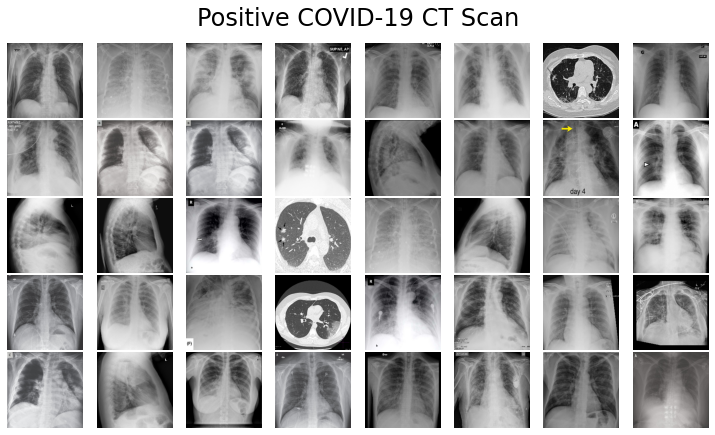

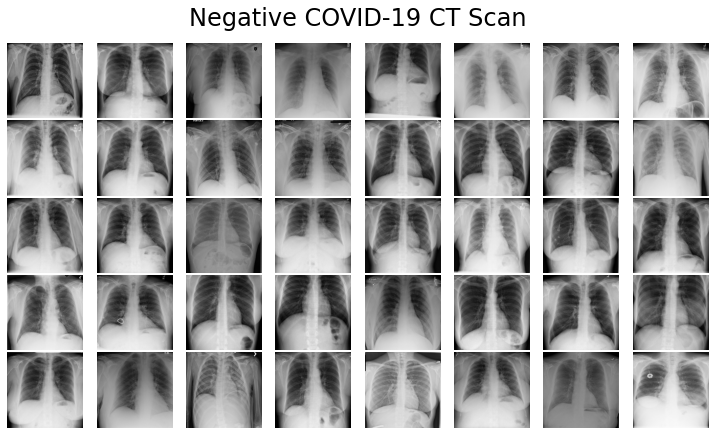

In [9]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 CT Scan')
plot_images(noncovid_images, 'Negative COVID-19 CT Scan')

### **Normalization**
#### Model takes images in the form of array of pixels. Hence convert into array and *normalize*

In [10]:
# Convert to array and Normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

### **Train Test Split**

In [11]:
# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

### Visualize a few images from Training and Test sets

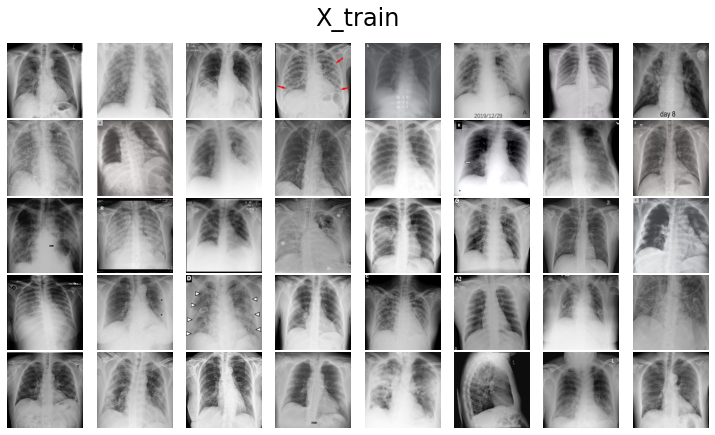

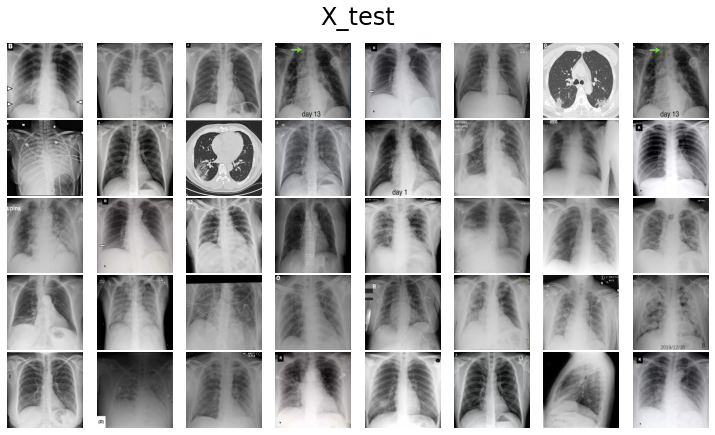

In [12]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

### **Building and Visualizing model**

In [13]:
inception = InceptionV3(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = inception.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=inception.input, outputs=outputs)

for layer in inception.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

87916544/87910968 [==============================] - 1s 0us/step


In [14]:
# Visualize Model
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

### **Image Augmentation**
#### To train on images at different positions, angles, flips, etc

In [15]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

In [16]:
epochs=500

### **Training the model**

In [17]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Epoch 1/500
24/23 [==============================] - 8s 350ms/step - loss: 3.6272 - accuracy: 0.6755 - val_loss: 1.2387 - val_accuracy: 0.7766
Epoch 2/500
24/23 [==============================] - 7s 293ms/step - loss: 1.2692 - accuracy: 0.8165 - val_loss: 0.8268 - val_accuracy: 0.8351
Epoch 3/500
24/23 [==============================] - 7s 290ms/step - loss: 0.6336 - accuracy: 0.8670 - val_loss: 0.6136 - val_accuracy: 0.8138
Epoch 4/500
24/23 [==============================] - 7s 292ms/step - loss: 0.7747 - accuracy: 0.8484 - val_loss: 1.0277 - val_accuracy: 0.7926
Epoch 5/500
24/23 [==============================] - 7s 290ms/step - loss: 0.6269 - accuracy: 0.8883 - val_loss: 0.7259 - val_accuracy: 0.8032
Epoch 6/500
24/23 [==============================] - 7s 291ms/step - loss: 1.0974 - accuracy: 0.8231 - val_loss: 0.8025 - val_accuracy: 0.8511
Epoch 7/500
24/23 [==============================] - 7s 297ms/step - loss: 0.8200 - accuracy: 0.8737 - val_loss: 0.5981 - val_accuracy: 0.8830

In [18]:
# Save Model and Weights
model.save('inception_ct.h5')
model.save_weights('inception_weights_ct.hdf5')

In [19]:
# Load saved model
model = load_model('inception_ct.h5')

### **Making Predicions**

In [20]:
y_pred = model.predict(X_test, batch_size=batch_size)

### Visulaizing First 10 predictions

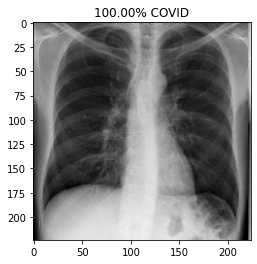

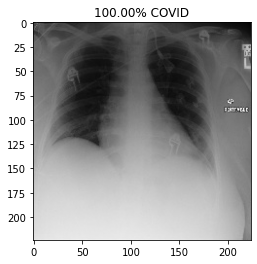

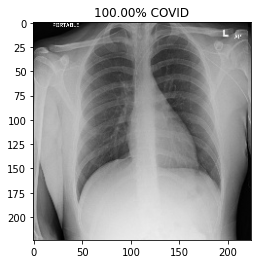

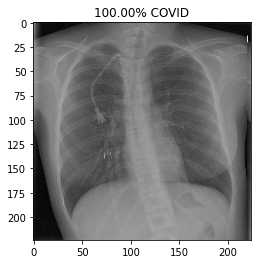

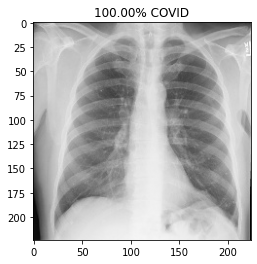

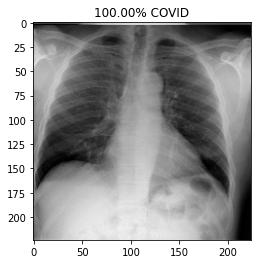

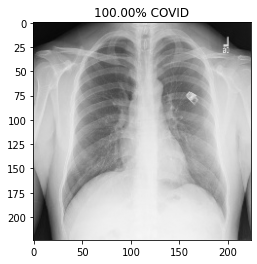

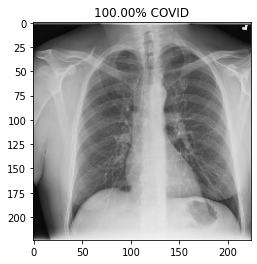

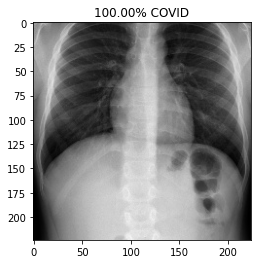

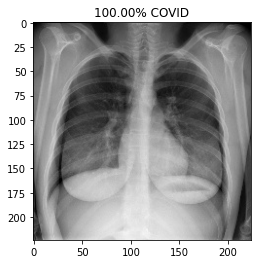

In [21]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.style.reload_library
  plt.imshow(X_test[index])
  plt.show()

In [22]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### Plot ROC Curve

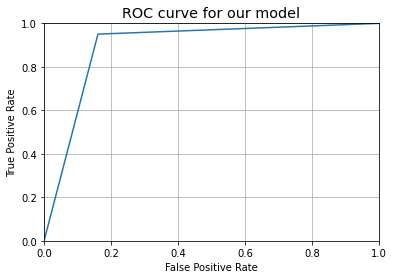

In [23]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### Plot Confusion Matrix

Confusion Matrix without Normalization


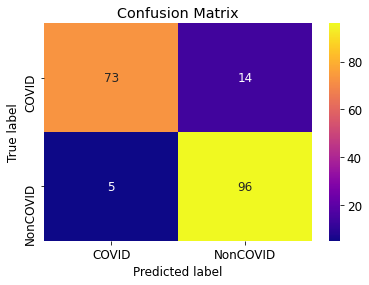

Confusion Matrix with Normalized Values


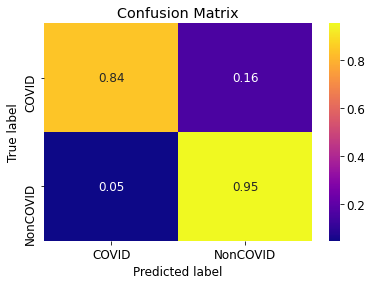

In [24]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

### **Classification Report**

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.94      0.84      0.88        87
           1       0.87      0.95      0.91       101

    accuracy                           0.90       188
   macro avg       0.90      0.89      0.90       188
weighted avg       0.90      0.90      0.90       188



### **Accuracy and Loss Plots**

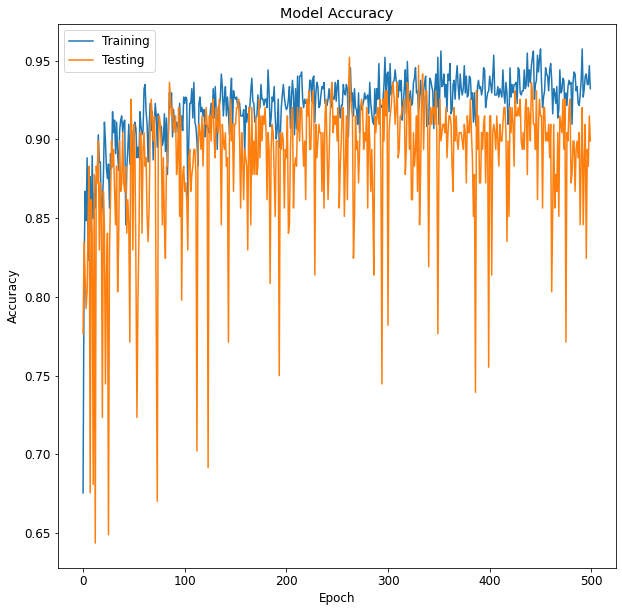

In [26]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_ct_accuracy.png')
plt.show()


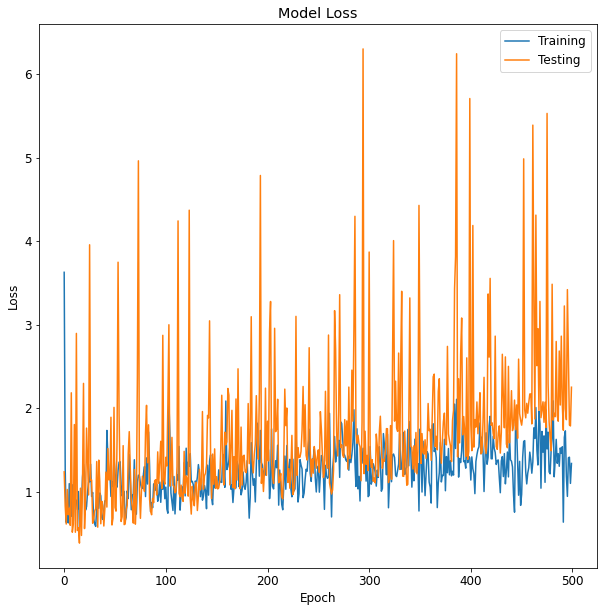

In [27]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('inception_ct_loss.png')
plt.show()